
<table><tr>
    <td><img src="imagenes/Macc.png"/></td>
    <td><p style="font-size:18pt">Semillero de Modelación y Simulación de Fenómenos Sociales</p></td>
</tr></table>

<p align="right" style="font-size:10pt">Versión 2021-1</p>

# Simulación del Modelo del bar El Farol

## Descripción del juego iterativo

En el presente modelo se tiene una población de $N$ individuos, quienes deben tomar la decisión de si acudirán o no al bar llamado "El Farol". Cada agente toma esta decisión de manera independiente a los demás, y todos lo hacen de manera simultánea. 

<table><tr>
    <td><img src="imagenes/ElFarol1.jpeg"/></td>
    <td><img src="imagenes/ElFarol2.jpeg"/></td>
</tr></table>

Si el total de acudientes supera un umbral $\mu$, entonces El Farol se congestionará y los individuos que hayan ido no tendrán una buena experiencia (recompensa=-1). Por otro lado, si el total de los acudientes no supera este umbral, quienes hayan asistido podrán disfrutar de su estadía en el bar (recompensa=1). Adicionalmente, si un individuo no asiste al bar, será indiferente al estado de El Farol (recompensa=0). Cada agente intentará tomar la mejor decisión posible con respecto a asistir o no al bar. Esta situación se repetirá por un número $k$ de iteraciones. 

## Implementación en Python

#### AGENTES 

Los agentes que se simularán tendrán 2 atributos:

`estado`: Es la estrategia tomada por el agente y que puede ser ir al bar (1) o abstenerse de ir (0).

`puntaje`: Puntaje obtenido. Hay tres posibilidades:

- **1** Si fue y la proporción de agentes que fueron fue menor que el $\mu $ determinado ($\mu=0.5$).
- **0**, si decidió no ir.
- **-1**, si fue y la proporción de agentes que fueron fue mayor que el $\mu$ determinado ($\mu=0.5$).

La impementación en Python de estos atributos tiene la característica siguiente. Cada atributo se almacena como una lista, la cual guarda la información correspondiente por cada ronda. Esto es, por ejemplo, `agente.estado[0]` es el estado del agente en la primera ronda.

Los agentes tendrán 2 métodos:

`toma_decision`(`modelo`, `parametros`): Es el método que le dice al agente qué estrategia seguir, la cual se decidirá de acuerdo al `modelo` seleccionado con los `parametros` dados.

`imprime_agente(r)`: imprime los datos del agente en la ronda `r`.

In [1]:
import pandas as pd

In [2]:
from random import uniform

class Agente :
    
    def __init__(self, estados, puntajes, atractivo) :
        self.estado = estados # lista
        self.puntaje = puntajes # lista
        self.atractivo = atractivo
        
    def toma_decision(self, modelo='aleatorio', parametros=[0.5], DEB=False) :
        '''
        Se lanza un "dado" para decidir aleatoriamente si el agente va o no al bar
        de acuerdo a si supera el umbral dado por el valor de para_ir
        '''
        atractivo=self.atractivo # Valor por defecto

        # determina el valor de para_ir de acuerdo al modelo y sus parámetros
        if modelo == 'aleatorio' :
            atractivo=parametros[0]
        
        if modelo == 'rescorla-wagner' :
            recompensa=(self.puntaje[-1]+1)/2
            alfa=parametros[0]
            q0=parametros[1]
            atractivo=self.atractivo+alfa*(recompensa-self.atractivo)
            if DEB :
                print(f"atractivo anterior:{self.atractivo}; atractivo nuevo:{atractivo}")
            self.atractivo=atractivo

        if modelo == 'win-stay-lose-shift' :
            epsilon = parametros[0]
            gamma = parametros[1]
            if self.puntaje[-1] >= gamma :
                atractivo = 1 - epsilon/2
            else:
                atractivo = epsilon/2
            self.atractivo = atractivo

        # Lanza el dado
        if uniform(0,1) < atractivo :
            self.estado.append(1)
        else :
            self.estado.append(0)

    def imprime_agente(self, ronda) :
        try:
            estado = self.estado[ronda]
        except:
            estado = "nan"
        try:
            puntaje = self.puntaje[ronda]
        except:
            puntaje = "nan"

        return "Estado:{0}, Puntaje:{1}".format(estado, puntaje)
            

#### BAR

El bar será un objeto con los siguientes atributos:

`num_agentes`: cantidad de agentes que pueden ir al bar.

`agentes`: agentes que pueden ir al bar.

`umbral`: proporción de `agentes` que puede ir al bar para que la velada sea agradable.

`num_iteraciones`: cantidad de rondas.

`historia`: lista de la asistencia en todas las rondas pasadas.

El bar tendrá los siguientes métodos:

`calcular_asistencia()`: determina la cantidad de `agentes` que tomaron la decisión de ir al bar y actualiza la `historia`.

`calcular_puntajes()`: determina los puntajes de los `agentes` de acuerdo a la asistencia y a las decisiones respectivas. 

`agentes_deciden()`: solicita a los agentes que tomen una decisión.

`imprime_ronda(r)`: imprime la ronda `r`-ésima.

In [3]:
from random import randint, uniform
import numpy as np

class BarElFarol :
    
    def __init__(self, num_agentes, umbral, num_iteraciones, modelo='aleatorio', parametros=[.5]) :
        self.num_agentes = num_agentes
        self.umbral = umbral
        self.num_iteraciones = num_iteraciones
        self.historia = []
        self.agentes = []
        for i in range(self.num_agentes) :
            if modelo == 'aleatorio' :
                self.agentes.append(Agente([randint(0,1)], [], parametros[0]))        
            if modelo == 'rescorla-wagner' :
                self.agentes.append(Agente([randint(0,1)], [], parametros[1])) 
            if modelo == 'win-stay-lose-shift' :
                self.agentes.append(Agente([randint(0,1)], [], uniform(0,1))) 
            
    def calcular_asistencia(self) :
        asistencia = np.sum([a.estado[-1] for a in self.agentes])
        self.historia.append(asistencia)

    def calcular_puntajes(self) :
        asistencia = self.historia[-1]/self.num_agentes
        for a in self.agentes:
            if a.estado[-1] == 1:
                if asistencia > self.umbral:
                    a.puntaje.append(-1)
                else:
                    a.puntaje.append(1)
            else:
                a.puntaje.append(0)

    def agentes_deciden(self, modelo='aleatorio', parametros=[0.5], DEB=False) :
        for a in self.agentes :
            a.toma_decision(modelo, parametros, DEB=DEB)
                
    def imprime_ronda(self, ronda) :
        try:
            asistencia = self.historia[ronda]
        except:
            asistencia = "nan"
        cadena = '='*30
        cadena += f"\nRonda: {ronda} || Asistencia: {asistencia}"
        for a in self.agentes:
            cadena += "\n" + a.imprime_agente(ronda)
        print(cadena)

Con las funciones anteriores, estamos listos para hacer la simulación, definiendo los parámetros iniciales:

In [4]:
num_agentes=2
umbral=0.6
num_iteraciones=5
modelo='win-stay-lose-shift'
epsilon=0
gamma=1
parametros=[epsilon,gamma]
bar=BarElFarol(
    num_agentes, 
    umbral, 
    num_iteraciones, 
    modelo='win-stay-lose-shift', 
    parametros=parametros
)
#bar.imprime_ronda(0)

In [5]:
DEB=True
for t in range(num_iteraciones) : 
    bar.calcular_asistencia()
    bar.calcular_puntajes()
    if DEB :
        bar.imprime_ronda(t)
    bar.agentes_deciden(modelo='win-stay-lose-shift', parametros=parametros, DEB=DEB)


Ronda: 0 || Asistencia: 2
Estado:1, Puntaje:-1
Estado:1, Puntaje:-1
Ronda: 1 || Asistencia: 0
Estado:0, Puntaje:0
Estado:0, Puntaje:0
Ronda: 2 || Asistencia: 0
Estado:0, Puntaje:0
Estado:0, Puntaje:0
Ronda: 3 || Asistencia: 0
Estado:0, Puntaje:0
Estado:0, Puntaje:0
Ronda: 4 || Asistencia: 0
Estado:0, Puntaje:0
Estado:0, Puntaje:0


<AxesSubplot:>

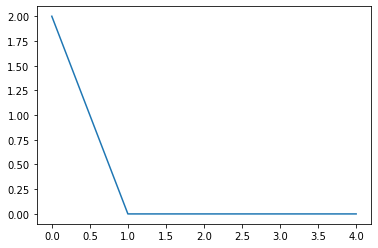

In [6]:
data = pd.DataFrame({'asistencia': bar.historia})
data['asistencia'].plot()